# Pipline

Теперь вы можете объединить все части кода в единый алгоритм:

1. Тензорное модальное разложение (TBMD):
* Выполнить Tucker-разложение тензора 𝑋 для получения тензора 𝐴.

2. Оптимальное размещение сенсоров:
* Применить тензорное QR-разложение к 𝐴 для получения матрицы 𝑃.

3. Формирование измерений:
* Сформировать измерения 𝑌 с использованием 𝑃 и 𝑋.

4. Восстановление вектора весов 𝑥:
* Применить тензорное компрессивное измерение для восстановления 𝑥.

5. Восстановление поля 𝑋:
* Использовать 𝑥 и 𝐴 для восстановления 𝑋

# Download packages

In [1]:
%pip install -U tensorly torch

Note: you may need to restart the kernel to use updated packages.


# Import libraries

In [2]:
import numpy as np
import tensorly as tl
import math
import matplotlib.pyplot as plt


from PIL import Image
from pathlib import Path
from tensorly.decomposition import tucker
from tensorly import tenalg, tucker_to_tensor
from tensorly.tenalg import mode_dot
from typing import Set, Tuple, Union
from collections import defaultdict
from sklearn.model_selection import train_test_split

In [3]:
tl.set_backend('numpy')

In [4]:
SEED = 42

tl.check_random_state(SEED)
np.random.seed(SEED)

# Download data

In [5]:
# Путь к данным
dataset_path = Path("data/ExtendedYaleB/GroupedDataBySubject")  # Путь к данным

# Считываем данные по субъектам
subject_images = defaultdict(list)
for subject_dir in dataset_path.iterdir():
    if subject_dir.is_dir():
        subject_id = subject_dir.name
        subject_images[subject_id] = list(subject_dir.glob("*.png"))

# Проверка на наличие данных
if not subject_images:
    raise ValueError("Данные для субъектов не найдены!")

# Функция для разбиения данных на train/test
def split_data_in_memory(subject_images, experiment_id, train_ratio=0.8):
    """
    Делит данные для каждого субъекта на тренировочный и тестовый наборы.
    Результаты возвращаются в виде словаря в памяти.
    """
    train_data = defaultdict(list)
    test_data = defaultdict(list)

    for subject, images in subject_images.items():
        # Разделение на train и test
        train_images, test_images = train_test_split(
            images, test_size=np.round(1-train_ratio, 1), random_state=experiment_id
        )
        train_data[subject].extend(train_images)
        test_data[subject].extend(test_images)

    return train_data, test_data

# Проведение 20 экспериментов с разными random_state
experiments_data = {}  # Хранение результатов всех экспериментов
for experiment_id in range(1, 21):
    train_data, test_data = split_data_in_memory(subject_images, experiment_id)
    experiments_data[experiment_id] = {"train": train_data, "test": test_data}

print("Все эксперименты успешно обработаны в памяти.")

Все эксперименты успешно обработаны в памяти.


In [6]:
# Обработка первого эксперимента
train_data = experiments_data[1]["train"]
test_data = experiments_data[1]["test"]

# Пример: подсчет количества изображений для каждого субъекта
for subject, images in train_data.items():
    print(f"Subject: {subject}, Train images: {len(images)}")

for subject, images in test_data.items():
    print(f"Subject: {subject}, Test images: {len(images)}")

# Пример: загрузка первого изображения для обработки
example_image_path = list(train_data["Subject_01"])[0]  # Получаем путь к изображению
with Image.open(example_image_path) as img:
    img_array = np.array(img)  # Преобразуем в numpy массив
    print("Размер изображения:", img_array.shape)

Subject: Subject_12, Train images: 48
Subject: Subject_15, Train images: 51
Subject: Subject_23, Train images: 52
Subject: Subject_24, Train images: 52
Subject: Subject_25, Train images: 52
Subject: Subject_22, Train images: 52
Subject: Subject_13, Train images: 48
Subject: Subject_31, Train images: 52
Subject: Subject_36, Train images: 52
Subject: Subject_09, Train images: 52
Subject: Subject_07, Train images: 52
Subject: Subject_38, Train images: 52
Subject: Subject_06, Train images: 52
Subject: Subject_39, Train images: 52
Subject: Subject_01, Train images: 52
Subject: Subject_37, Train images: 52
Subject: Subject_08, Train images: 52
Subject: Subject_30, Train images: 52
Subject: Subject_29, Train images: 52
Subject: Subject_16, Train images: 50
Subject: Subject_11, Train images: 48
Subject: Subject_18, Train images: 51
Subject: Subject_27, Train images: 52
Subject: Subject_20, Train images: 52
Subject: Subject_21, Train images: 52
Subject: Subject_19, Train images: 52
Subject: Sub

In [7]:
# Загрузка всех изображений для Subject_01 и создание тензора
subject_id = "Subject_01"  # Субъект для примера
image_paths = train_data[subject_id]  # Пути к изображениям для Subject_01

# Проверяем, что данные для Subject_01 существуют
if not image_paths:
    raise ValueError(f"Нет изображений для субъекта {subject_id} в тренировочных данных.")

# Сортируем изображения по имени, если необходимо (например, для временной последовательности)
image_paths = sorted(image_paths, key=lambda x: x.name)

# Инициализируем список для хранения изображений
image_slices = []

# Загрузка данных и перевод в float
def load_images_as_tensor(subject_images):
    """
    Загружает изображения для заданного субъекта и преобразует их в тензор float.
    """
    images = []
    for img_path in subject_images:
        with Image.open(img_path) as img:
            img_array = np.array(img.convert("L"), dtype=np.float32)  # Перевод в grayscale и float
            img_array /= 255.0  # Нормализация в диапазон [0, 1]
            images.append(img_array)
    return np.stack(images, axis=-1)  # Создаем тензор (H, W, T)

# Пример: обработка данных для одного субъекта
subject = "Subject_01"
tensor = load_images_as_tensor(train_data[subject])
print(f"Размеры исходного тензора для {subject}: {tensor.shape}")

Размеры исходного тензора для Subject_01: (42, 48, 52)


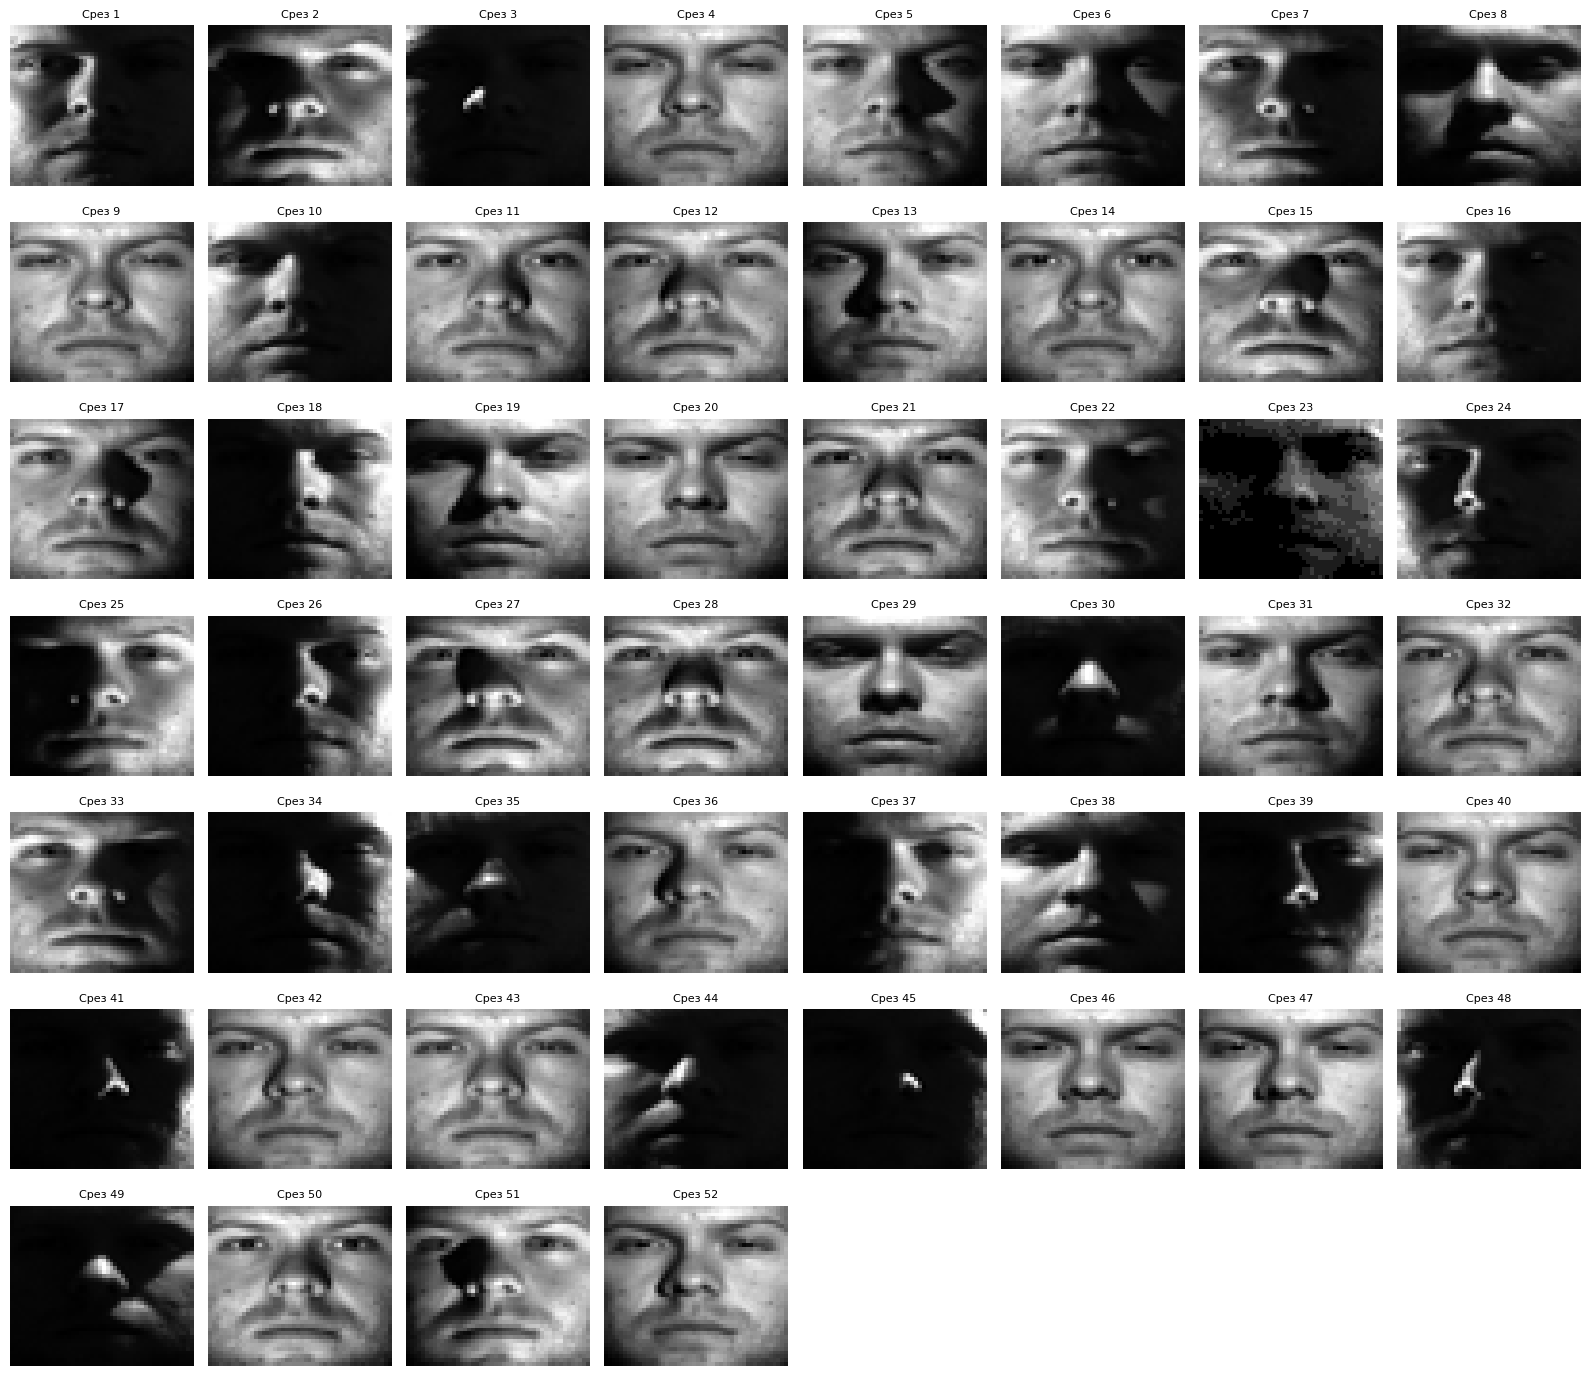

In [8]:
# Определяем количество изображений
num_images = tensor.shape[2]  # Количество срезов по третьей оси (временной)

# Рассчитываем количество строк и столбцов для субплотов
cols = 8  # Задаем фиксированное количество столбцов
rows = math.ceil(num_images / cols)  # Рассчитываем количество строк

# Визуализация всех изображений
plt.figure(figsize=(cols * 2, rows * 2))  # Увеличиваем размер графика пропорционально

for idx in range(num_images):
    plt.subplot(rows, cols, idx + 1)
    plt.imshow(tensor[:, :, idx], cmap="gray")
    plt.title(f"Срез {idx + 1}", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [9]:
# Создаем словарь для хранения тензоров по субъектам
tensors_by_subject = {}

# Загружаем изображения для всех субъектов и создаем тензоры
for subject in train_data:
    tensor = load_images_as_tensor(train_data[subject])
    tensors_by_subject[subject] = tensor
    print(f"Subject {subject} tensor shape: {tensor.shape}")

# Проверяем минимальное количество изображений у субъектов
num_images = {subject: tensor.shape[-1] for subject, tensor in tensors_by_subject.items()}
min_images = min(num_images.values())
print(f"Минимальное количество изображений: {min_images}")

# Приведение тензоров к одинаковому размеру
for subject in tensors_by_subject:
    tensor = tensors_by_subject[subject]
    if tensor.shape[-1] > min_images:
        # Обрезаем лишние кадры
        tensors_by_subject[subject] = tensor[:, :, :min_images]
    elif tensor.shape[-1] < min_images:
        # Повторяем последние кадры для дополнения
        padding = min_images - tensor.shape[-1]
        last_frame = np.expand_dims(tensor[:, :, -1], axis=-1)  # Последний кадр
        padding_frames = np.repeat(last_frame, padding, axis=-1)
        tensors_by_subject[subject] = np.concatenate((tensor, padding_frames), axis=-1)

# Стекаем тензоры по субъектам вдоль новой оси
stacked_tensor = np.stack(list(tensors_by_subject.values()), axis=-1)
print(f"Stacked tensor shape: {stacked_tensor.shape}")

Subject Subject_12 tensor shape: (42, 48, 48)
Subject Subject_15 tensor shape: (42, 48, 51)
Subject Subject_23 tensor shape: (42, 48, 52)
Subject Subject_24 tensor shape: (42, 48, 52)
Subject Subject_25 tensor shape: (42, 48, 52)
Subject Subject_22 tensor shape: (42, 48, 52)
Subject Subject_13 tensor shape: (42, 48, 48)
Subject Subject_31 tensor shape: (42, 48, 52)
Subject Subject_36 tensor shape: (42, 48, 52)
Subject Subject_09 tensor shape: (42, 48, 52)
Subject Subject_07 tensor shape: (42, 48, 52)
Subject Subject_38 tensor shape: (42, 48, 52)
Subject Subject_06 tensor shape: (42, 48, 52)
Subject Subject_39 tensor shape: (42, 48, 52)
Subject Subject_01 tensor shape: (42, 48, 52)
Subject Subject_37 tensor shape: (42, 48, 52)
Subject Subject_08 tensor shape: (42, 48, 52)
Subject Subject_30 tensor shape: (42, 48, 52)
Subject Subject_29 tensor shape: (42, 48, 52)
Subject Subject_16 tensor shape: (42, 48, 50)
Subject Subject_11 tensor shape: (42, 48, 48)
Subject Subject_18 tensor shape: (

# Applying TBMD to each tensor

Применяем тензорное модальное разложение (TBMD), в данном случае Tucker разложение, к каждому тензору, получая модальные тензоры 𝑀1, 𝑀2, …, 𝑀𝐷.

In [10]:
# cores_by_subject = {}
# factors_by_subject = {}

# epsilon = 1e-2  # Порог сходимости

# for subject, tensor in tensors_by_subject.items():
#     # Determine ranks based on the minimal dimension of the tensor
#     ranks = [min(tensor.shape)] * len(tensor.shape)
#     # Perform Tucker decomposition
#     core, factors = tucker(tensor, rank=ranks, tol=epsilon, random_state=SEED)
#     # Store the results
#     cores_by_subject[subject] = core
#     factors_by_subject[subject] = factors
#     # Print shapes for verification
#     print(f"Subject {subject}: Core shape {core.shape}")
#     print(f"Subject {subject}: Factors shapes {[f.shape for f in factors]}")

Subject Subject_12: Core shape (42, 42, 42)
Subject Subject_12: Factors shapes [(42, 42), (48, 42), (48, 42)]
Subject Subject_12: Reconstruction error: 0.01312


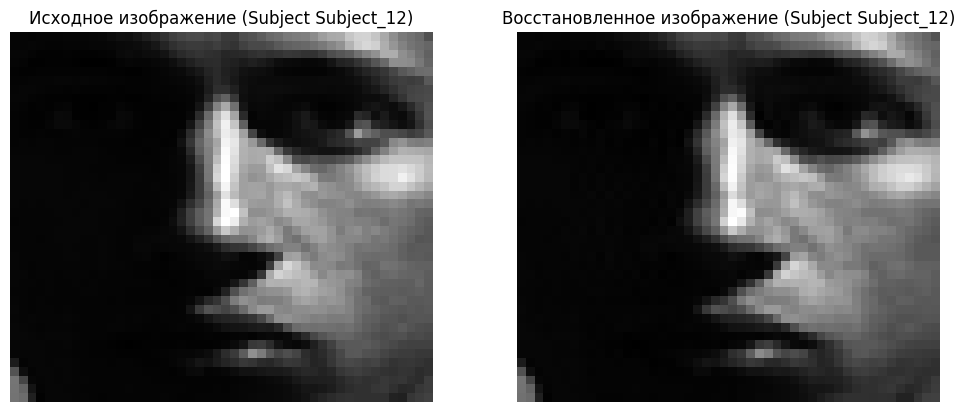

Subject Subject_15: Core shape (42, 42, 42)
Subject Subject_15: Factors shapes [(42, 42), (48, 42), (48, 42)]
Subject Subject_15: Reconstruction error: 0.01244


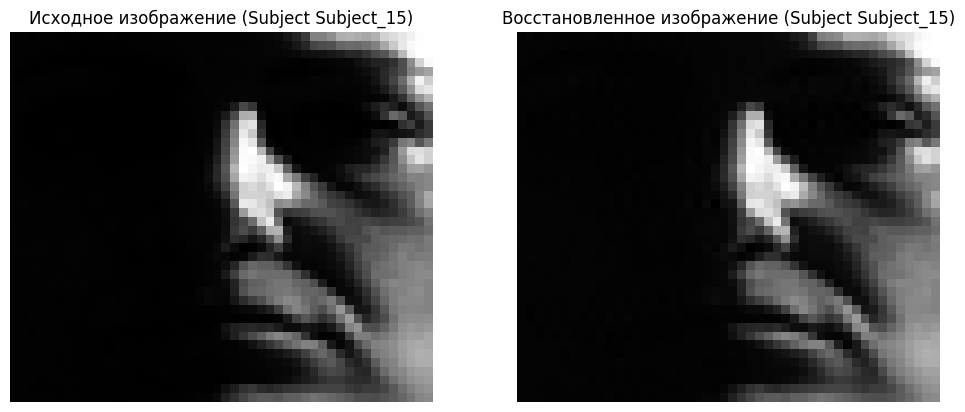

Subject Subject_23: Core shape (42, 42, 42)
Subject Subject_23: Factors shapes [(42, 42), (48, 42), (48, 42)]
Subject Subject_23: Reconstruction error: 0.01346


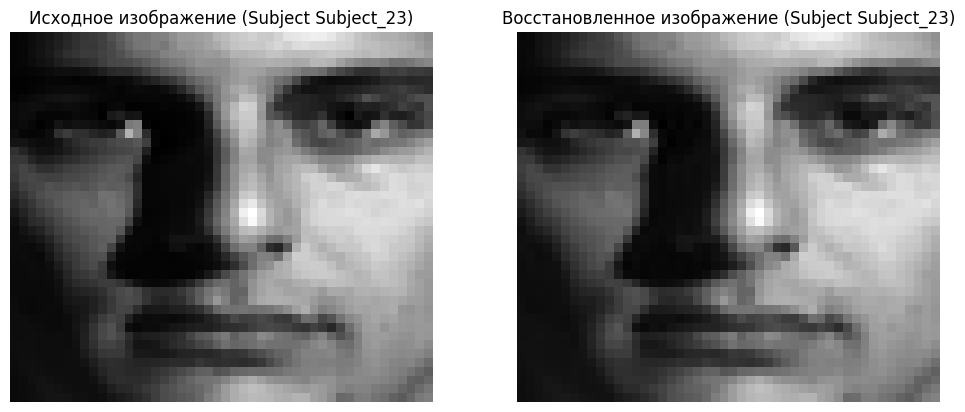

Subject Subject_24: Core shape (42, 42, 42)
Subject Subject_24: Factors shapes [(42, 42), (48, 42), (48, 42)]
Subject Subject_24: Reconstruction error: 0.01173


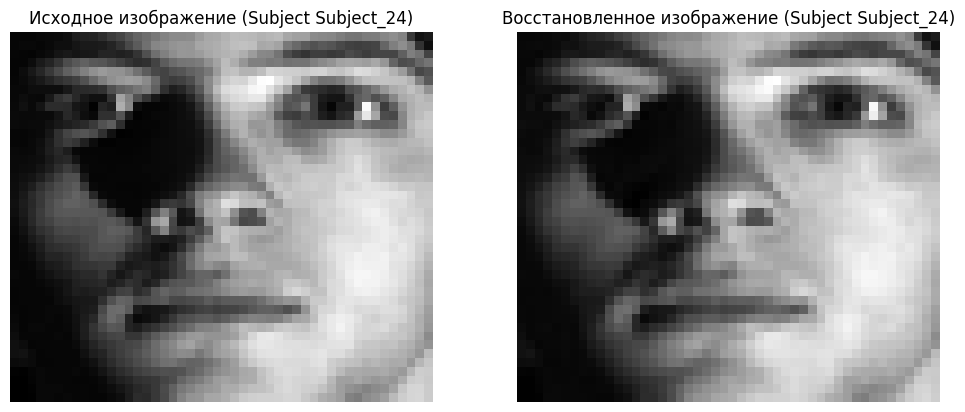

Subject Subject_25: Core shape (42, 42, 42)
Subject Subject_25: Factors shapes [(42, 42), (48, 42), (48, 42)]
Subject Subject_25: Reconstruction error: 0.01286


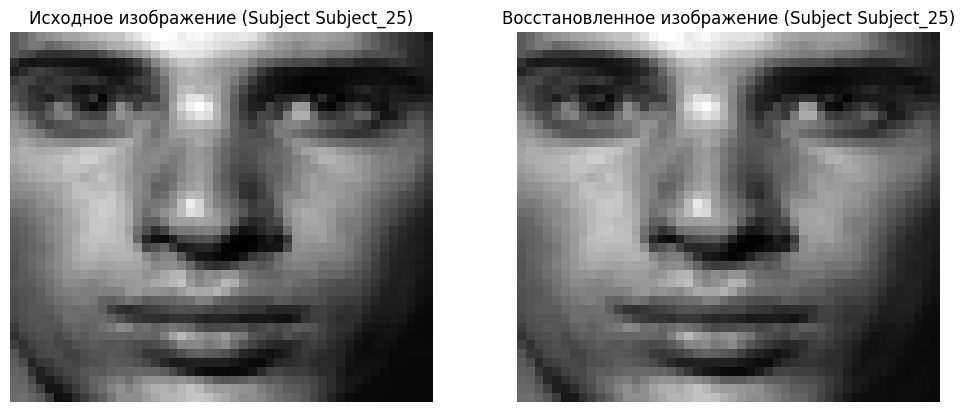

Subject Subject_22: Core shape (42, 42, 42)
Subject Subject_22: Factors shapes [(42, 42), (48, 42), (48, 42)]
Subject Subject_22: Reconstruction error: 0.01566


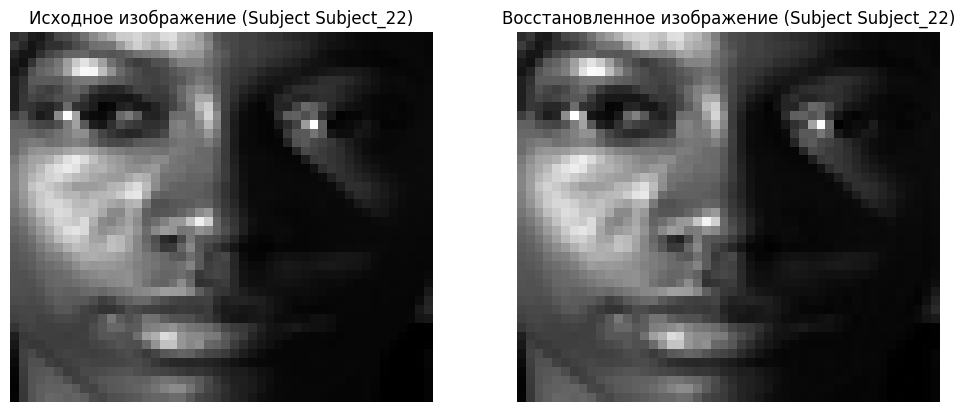

Subject Subject_13: Core shape (42, 42, 42)
Subject Subject_13: Factors shapes [(42, 42), (48, 42), (48, 42)]
Subject Subject_13: Reconstruction error: 0.00934


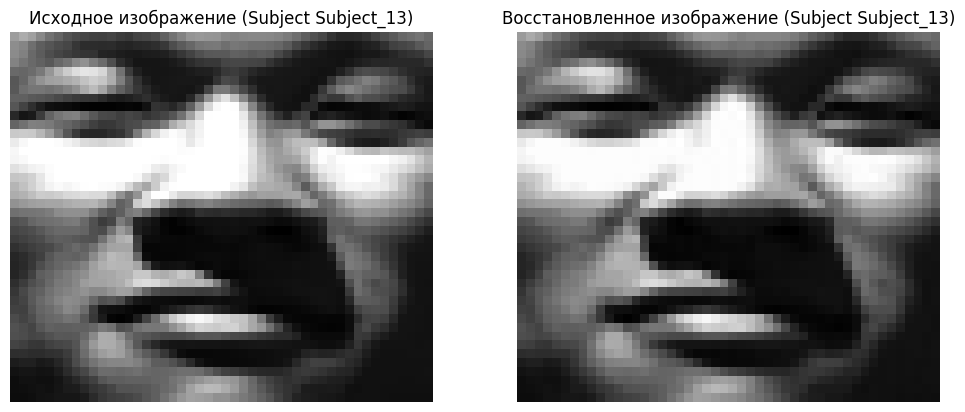

Subject Subject_31: Core shape (42, 42, 42)
Subject Subject_31: Factors shapes [(42, 42), (48, 42), (48, 42)]
Subject Subject_31: Reconstruction error: 0.00976


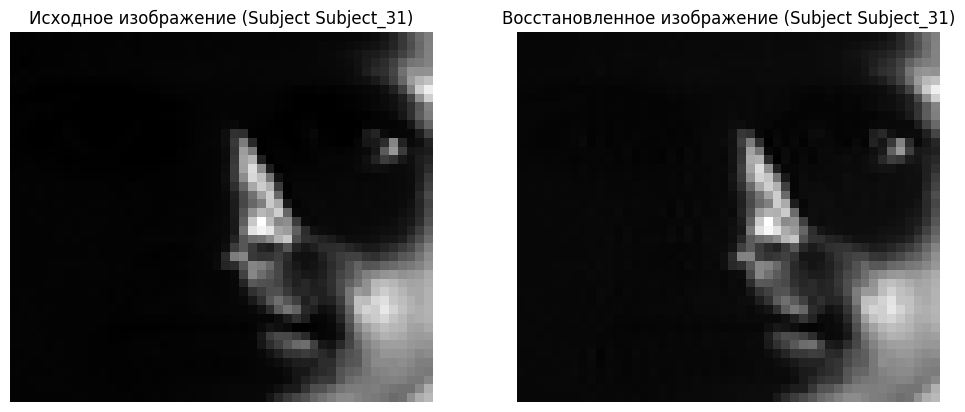

Subject Subject_36: Core shape (42, 42, 42)
Subject Subject_36: Factors shapes [(42, 42), (48, 42), (48, 42)]
Subject Subject_36: Reconstruction error: 0.01038


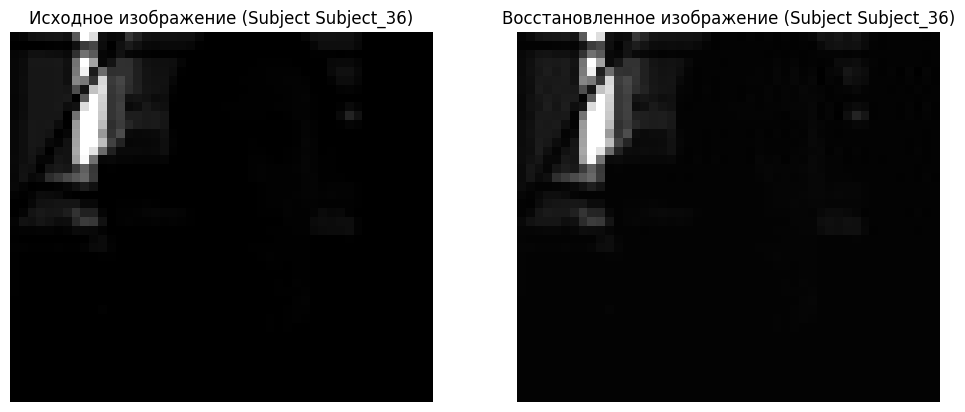

Subject Subject_09: Core shape (42, 42, 42)
Subject Subject_09: Factors shapes [(42, 42), (48, 42), (48, 42)]
Subject Subject_09: Reconstruction error: 0.00925


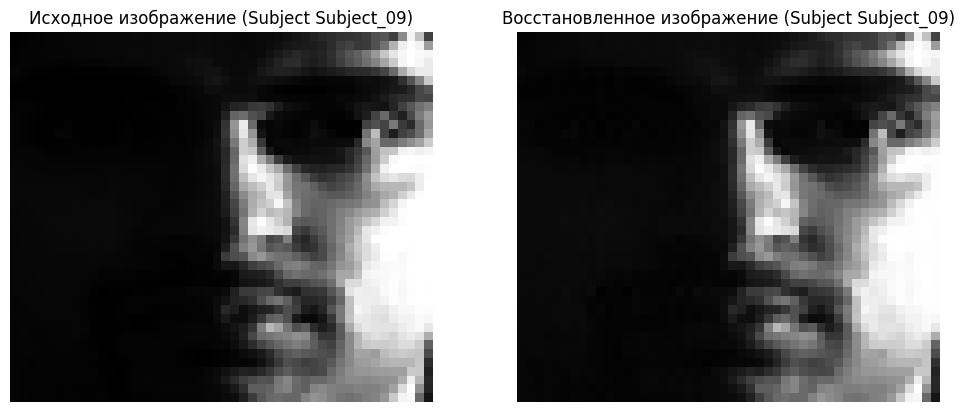

Subject Subject_07: Core shape (42, 42, 42)
Subject Subject_07: Factors shapes [(42, 42), (48, 42), (48, 42)]
Subject Subject_07: Reconstruction error: 0.00971


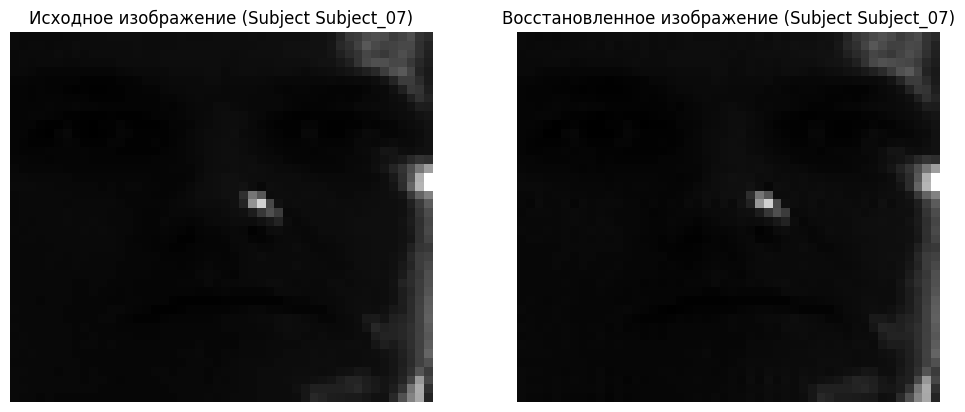

Subject Subject_38: Core shape (42, 42, 42)
Subject Subject_38: Factors shapes [(42, 42), (48, 42), (48, 42)]
Subject Subject_38: Reconstruction error: 0.00992


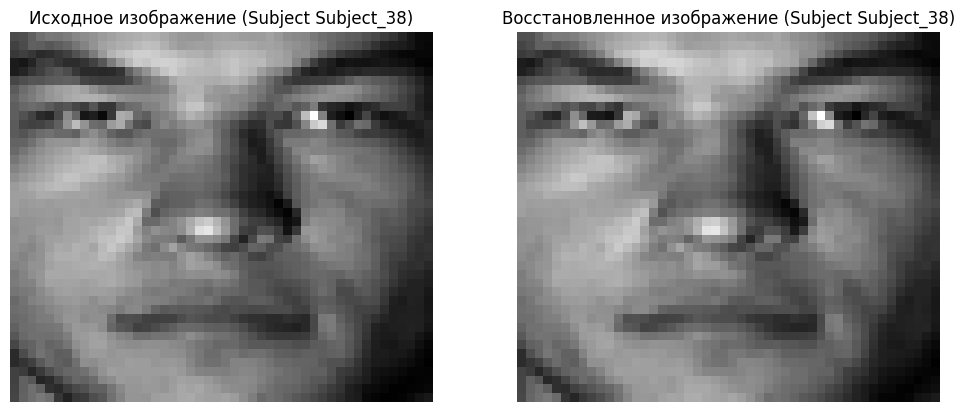

Subject Subject_06: Core shape (42, 42, 42)
Subject Subject_06: Factors shapes [(42, 42), (48, 42), (48, 42)]
Subject Subject_06: Reconstruction error: 0.01164


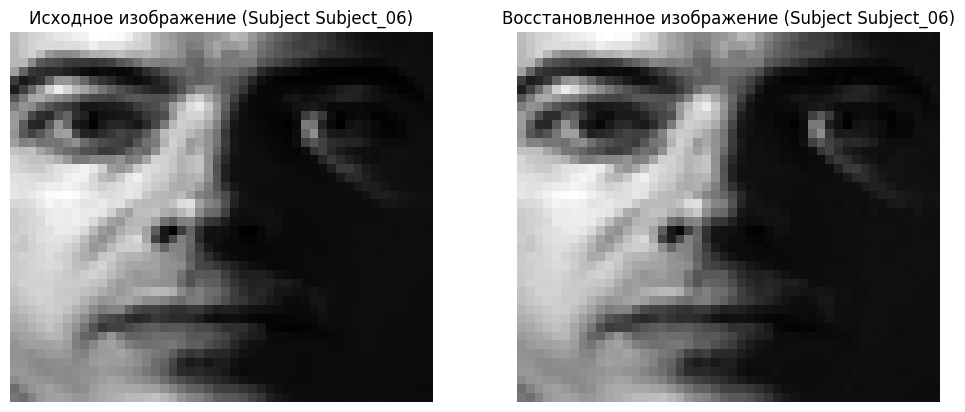

Subject Subject_39: Core shape (42, 42, 42)
Subject Subject_39: Factors shapes [(42, 42), (48, 42), (48, 42)]
Subject Subject_39: Reconstruction error: 0.01197


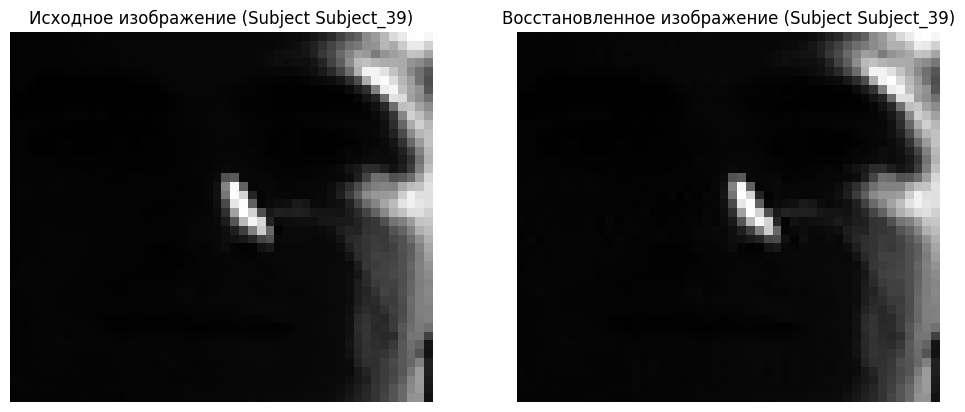

Subject Subject_01: Core shape (42, 42, 42)
Subject Subject_01: Factors shapes [(42, 42), (48, 42), (48, 42)]
Subject Subject_01: Reconstruction error: 0.00911


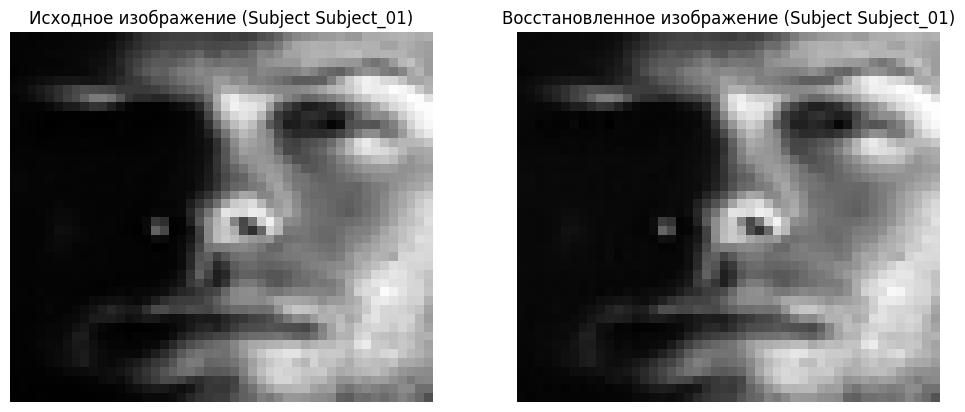

Subject Subject_37: Core shape (42, 42, 42)
Subject Subject_37: Factors shapes [(42, 42), (48, 42), (48, 42)]
Subject Subject_37: Reconstruction error: 0.00755


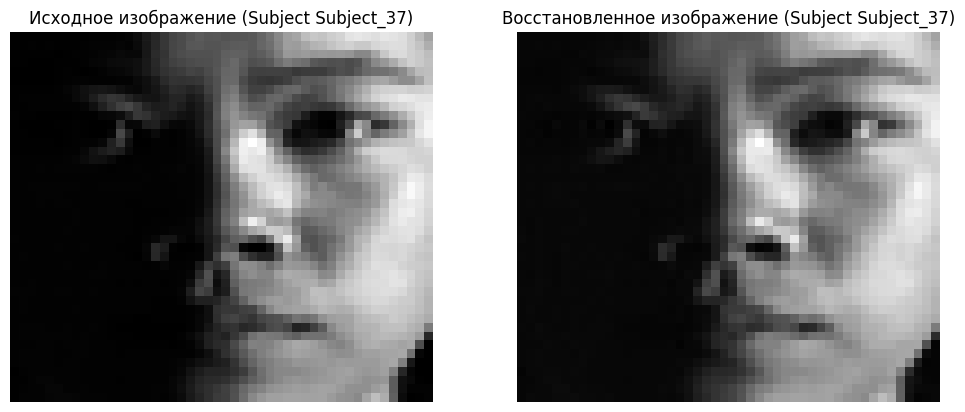

Subject Subject_08: Core shape (42, 42, 42)
Subject Subject_08: Factors shapes [(42, 42), (48, 42), (48, 42)]
Subject Subject_08: Reconstruction error: 0.01203


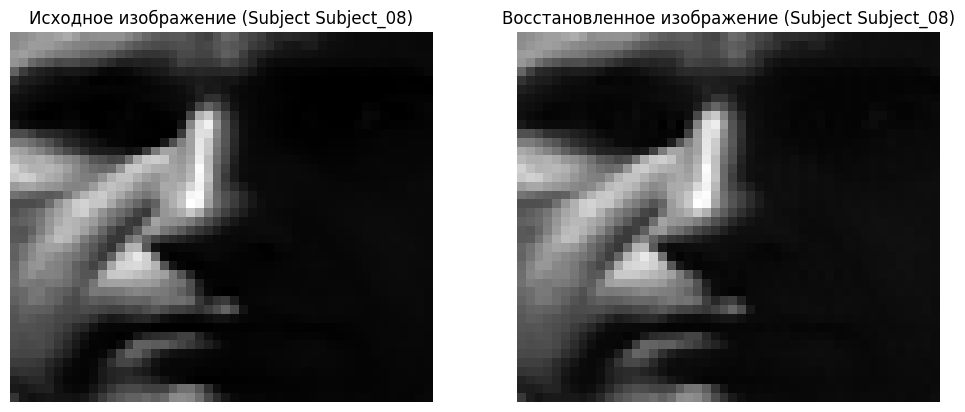

Subject Subject_30: Core shape (42, 42, 42)
Subject Subject_30: Factors shapes [(42, 42), (48, 42), (48, 42)]
Subject Subject_30: Reconstruction error: 0.01204


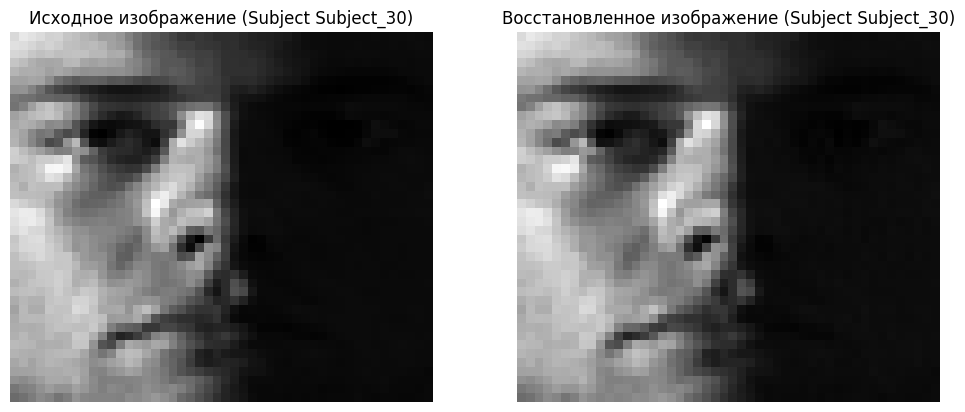

Subject Subject_29: Core shape (42, 42, 42)
Subject Subject_29: Factors shapes [(42, 42), (48, 42), (48, 42)]
Subject Subject_29: Reconstruction error: 0.01316


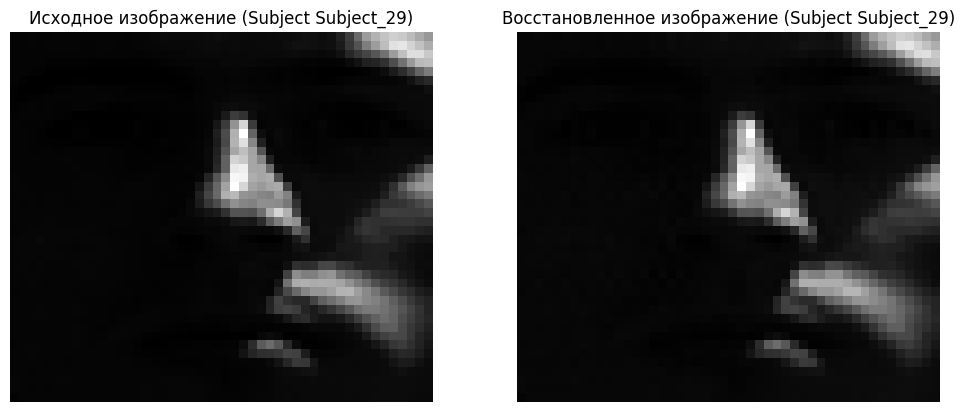

Subject Subject_16: Core shape (42, 42, 42)
Subject Subject_16: Factors shapes [(42, 42), (48, 42), (48, 42)]
Subject Subject_16: Reconstruction error: 0.01057


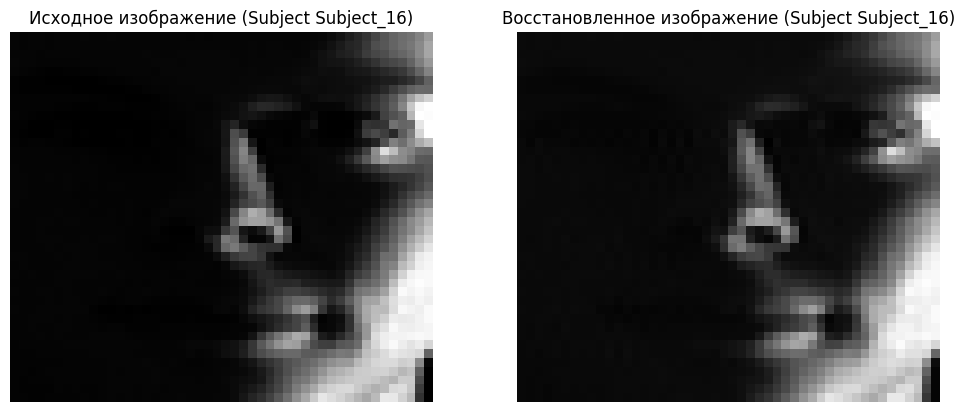

Subject Subject_11: Core shape (42, 42, 42)
Subject Subject_11: Factors shapes [(42, 42), (48, 42), (48, 42)]
Subject Subject_11: Reconstruction error: 0.01130


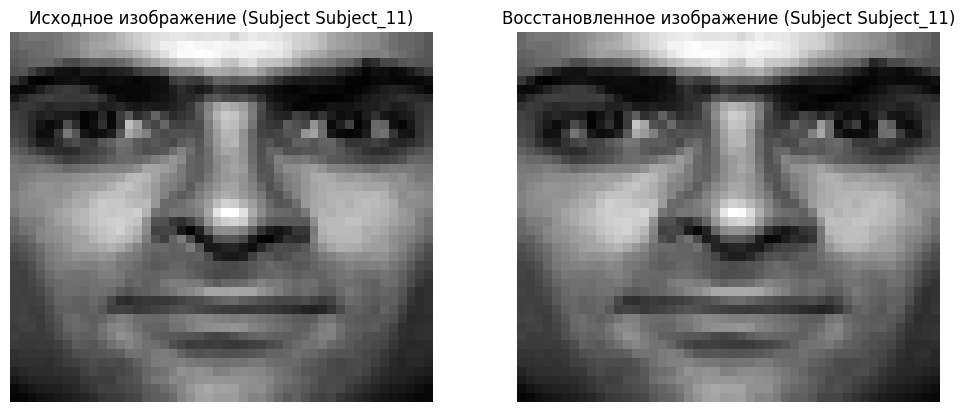

Subject Subject_18: Core shape (42, 42, 42)
Subject Subject_18: Factors shapes [(42, 42), (48, 42), (48, 42)]
Subject Subject_18: Reconstruction error: 0.01126


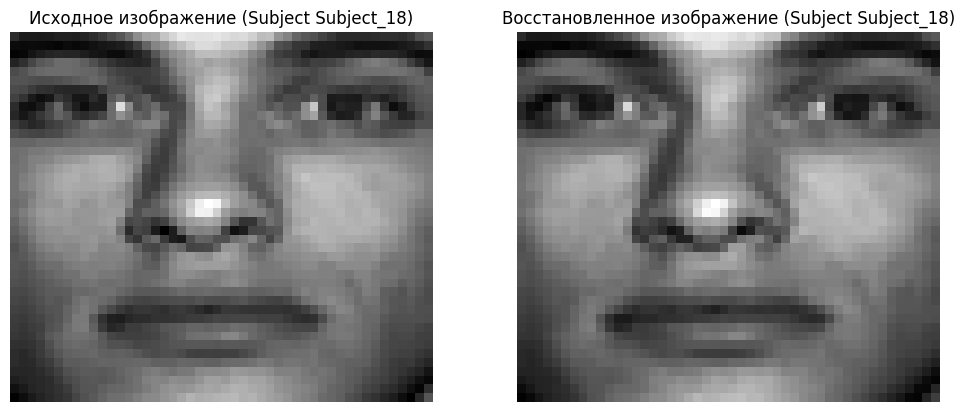

Subject Subject_27: Core shape (42, 42, 42)
Subject Subject_27: Factors shapes [(42, 42), (48, 42), (48, 42)]
Subject Subject_27: Reconstruction error: 0.01181


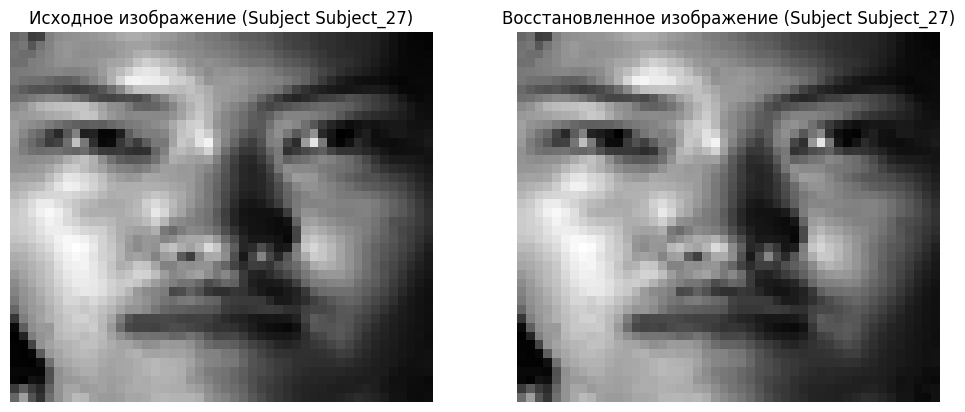

Subject Subject_20: Core shape (42, 42, 42)
Subject Subject_20: Factors shapes [(42, 42), (48, 42), (48, 42)]
Subject Subject_20: Reconstruction error: 0.00952


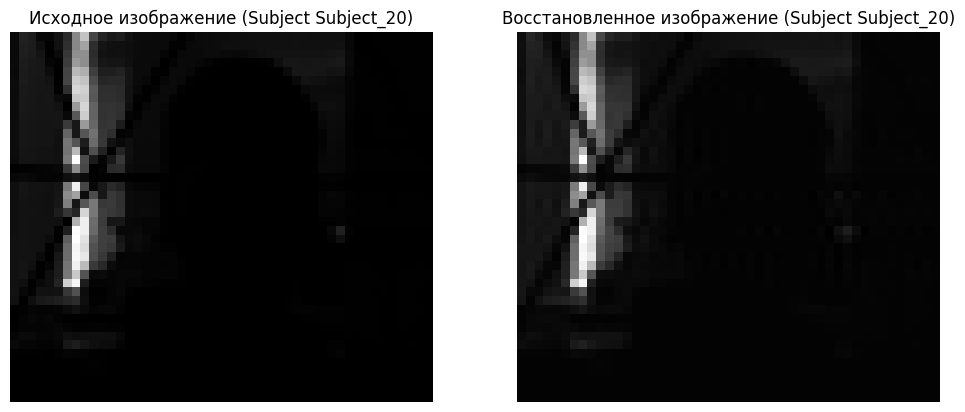

Subject Subject_21: Core shape (42, 42, 42)
Subject Subject_21: Factors shapes [(42, 42), (48, 42), (48, 42)]
Subject Subject_21: Reconstruction error: 0.01019


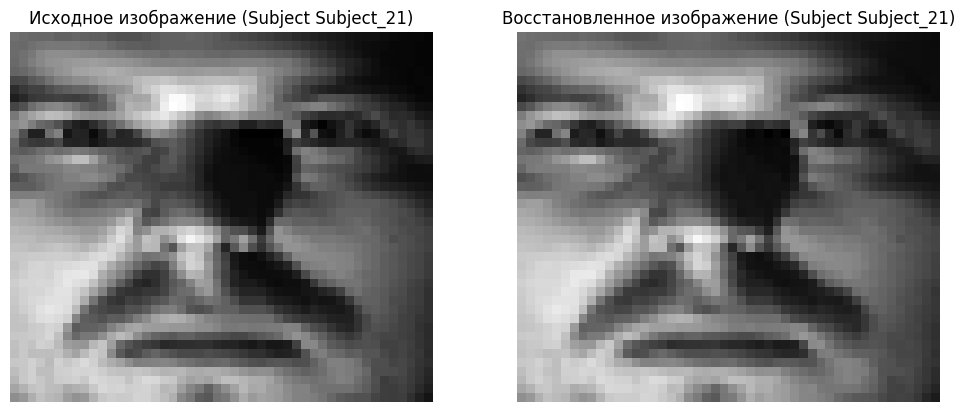

Subject Subject_19: Core shape (42, 42, 42)
Subject Subject_19: Factors shapes [(42, 42), (48, 42), (48, 42)]
Subject Subject_19: Reconstruction error: 0.01052


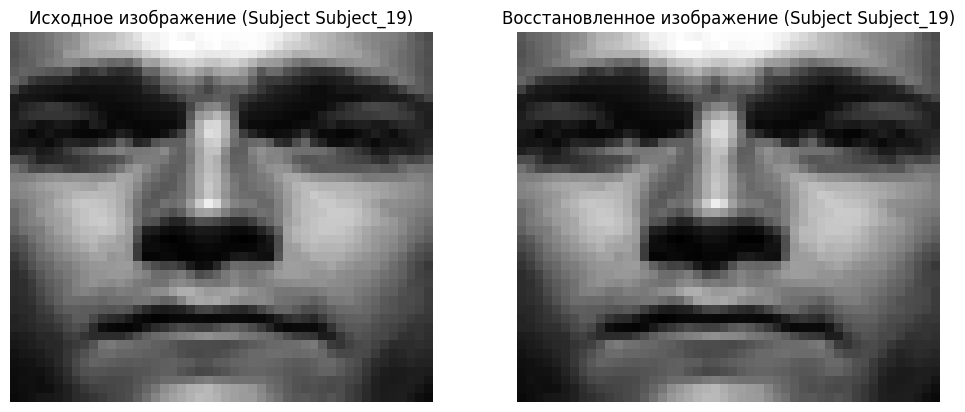

Subject Subject_26: Core shape (42, 42, 42)
Subject Subject_26: Factors shapes [(42, 42), (48, 42), (48, 42)]
Subject Subject_26: Reconstruction error: 0.01189


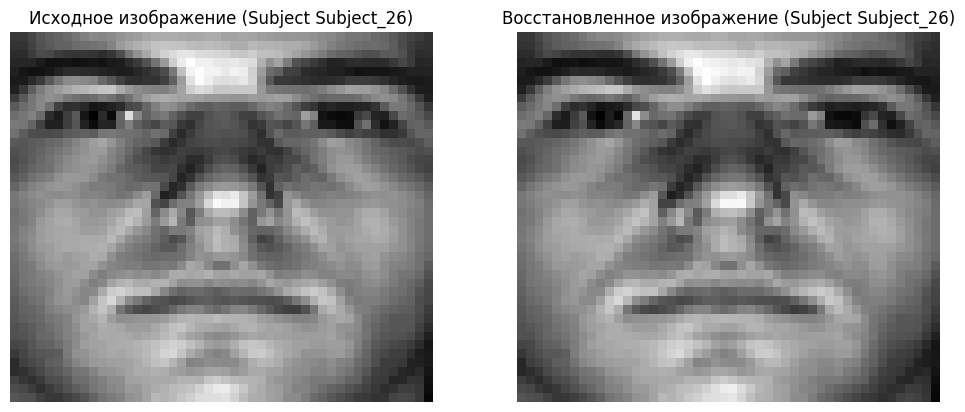

Subject Subject_10: Core shape (42, 42, 42)
Subject Subject_10: Factors shapes [(42, 42), (48, 42), (48, 42)]
Subject Subject_10: Reconstruction error: 0.01042


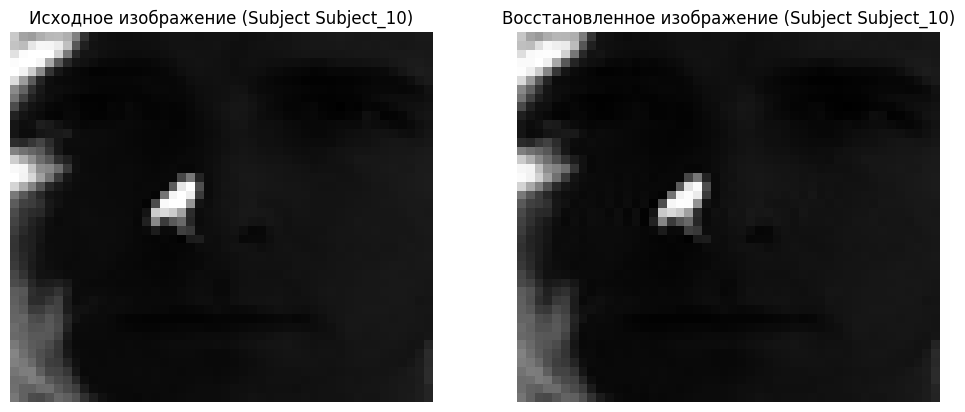

Subject Subject_28: Core shape (42, 42, 42)
Subject Subject_28: Factors shapes [(42, 42), (48, 42), (48, 42)]
Subject Subject_28: Reconstruction error: 0.01122


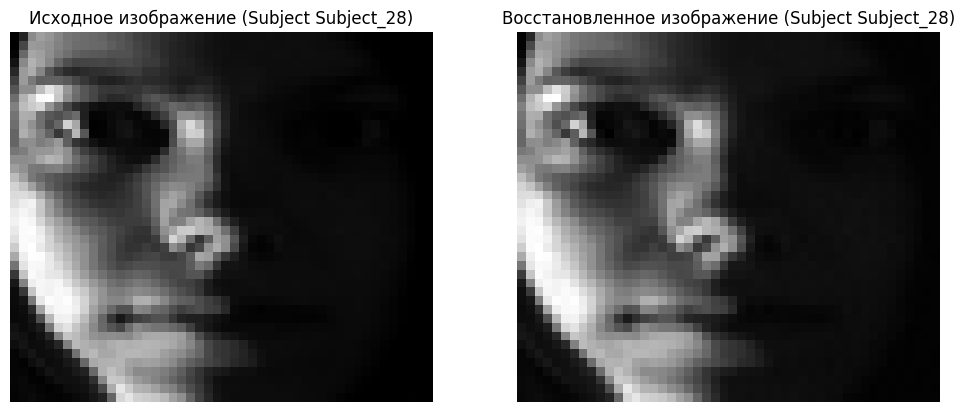

Subject Subject_17: Core shape (42, 42, 42)
Subject Subject_17: Factors shapes [(42, 42), (48, 42), (48, 42)]
Subject Subject_17: Reconstruction error: 0.01228


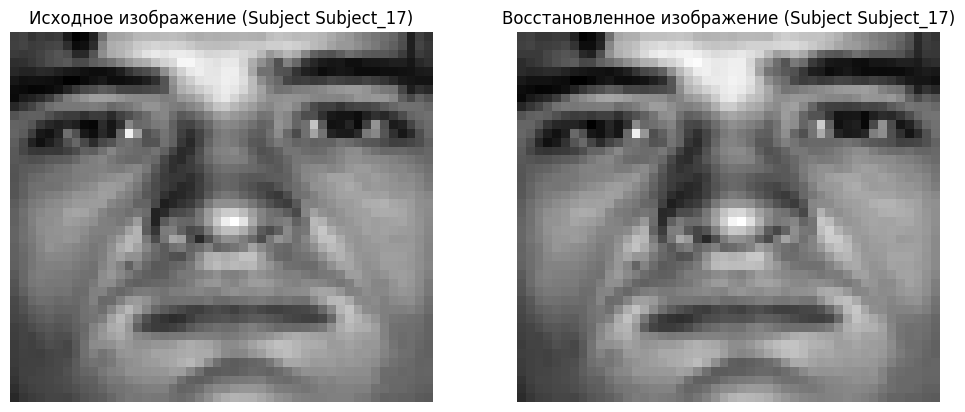

Subject Subject_35: Core shape (42, 42, 42)
Subject Subject_35: Factors shapes [(42, 42), (48, 42), (48, 42)]
Subject Subject_35: Reconstruction error: 0.01145


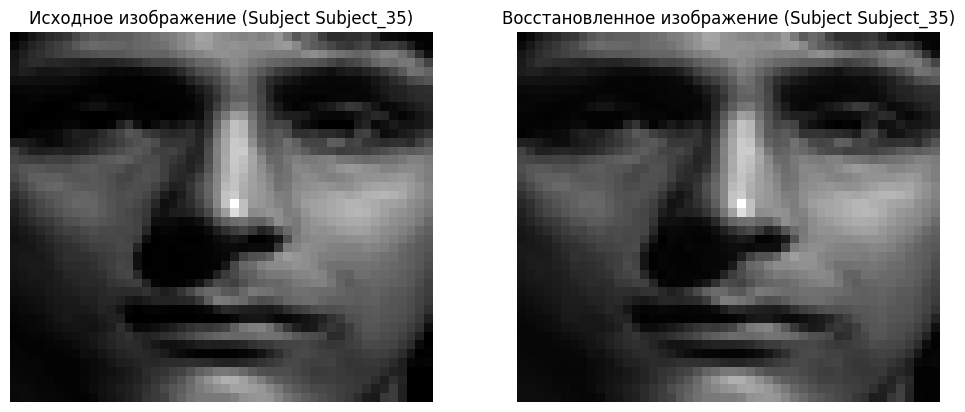

Subject Subject_32: Core shape (42, 42, 42)
Subject Subject_32: Factors shapes [(42, 42), (48, 42), (48, 42)]
Subject Subject_32: Reconstruction error: 0.01561


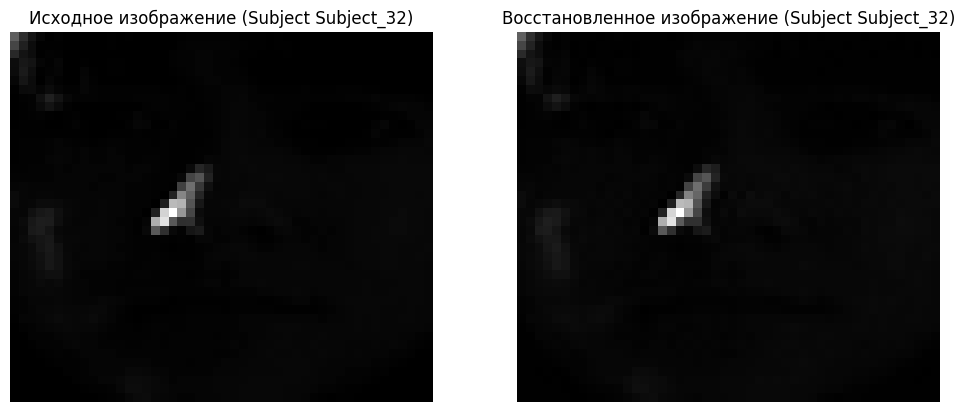

Subject Subject_04: Core shape (42, 42, 42)
Subject Subject_04: Factors shapes [(42, 42), (48, 42), (48, 42)]
Subject Subject_04: Reconstruction error: 0.00938


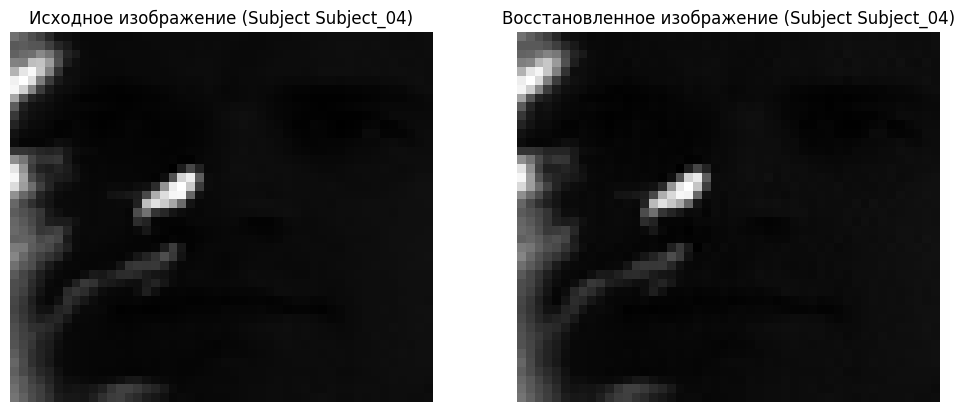

Subject Subject_03: Core shape (42, 42, 42)
Subject Subject_03: Factors shapes [(42, 42), (48, 42), (48, 42)]
Subject Subject_03: Reconstruction error: 0.01258


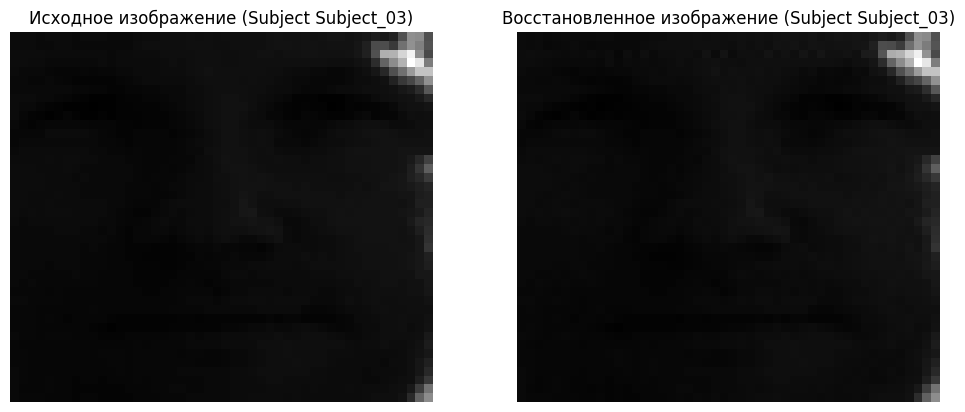

Subject Subject_02: Core shape (42, 42, 42)
Subject Subject_02: Factors shapes [(42, 42), (48, 42), (48, 42)]
Subject Subject_02: Reconstruction error: 0.00666


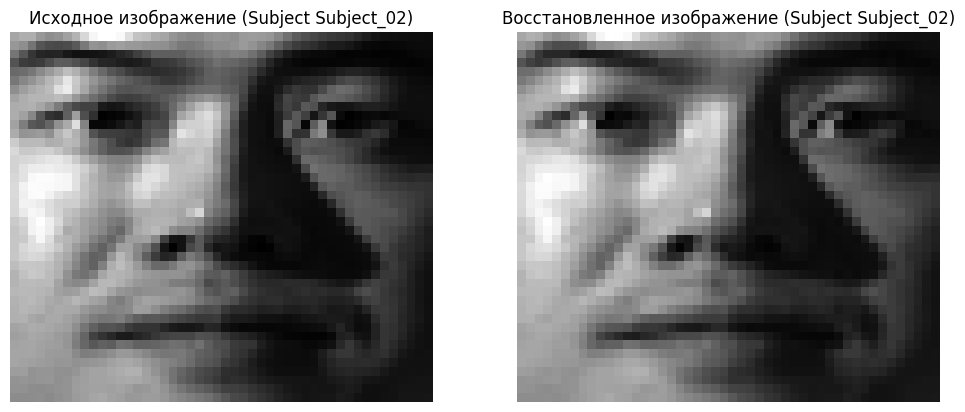

Subject Subject_05: Core shape (42, 42, 42)
Subject Subject_05: Factors shapes [(42, 42), (48, 42), (48, 42)]
Subject Subject_05: Reconstruction error: 0.01191


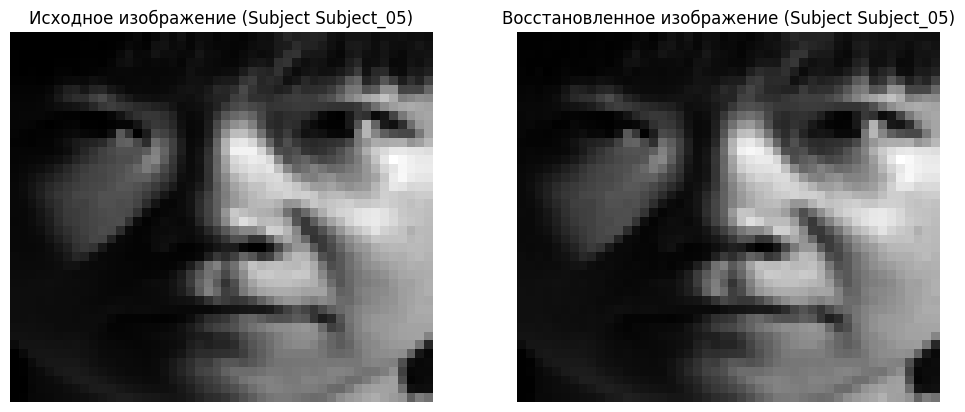

Subject Subject_33: Core shape (42, 42, 42)
Subject Subject_33: Factors shapes [(42, 42), (48, 42), (48, 42)]
Subject Subject_33: Reconstruction error: 0.01086


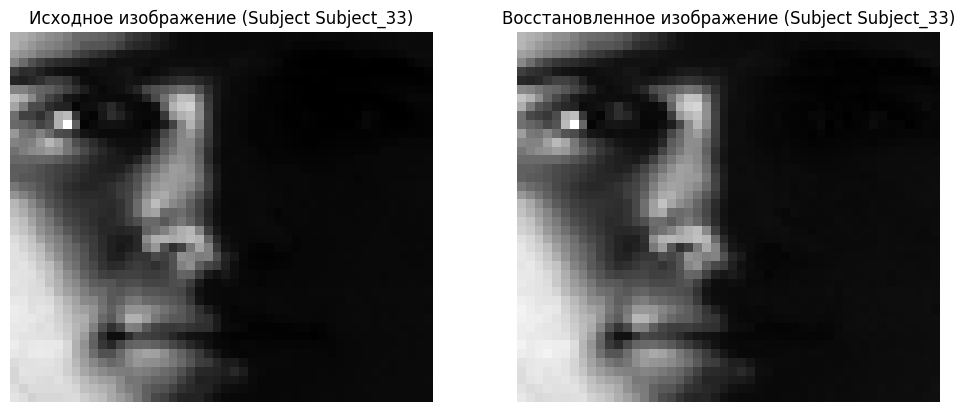

Subject Subject_34: Core shape (42, 42, 42)
Subject Subject_34: Factors shapes [(42, 42), (48, 42), (48, 42)]
Subject Subject_34: Reconstruction error: 0.01180


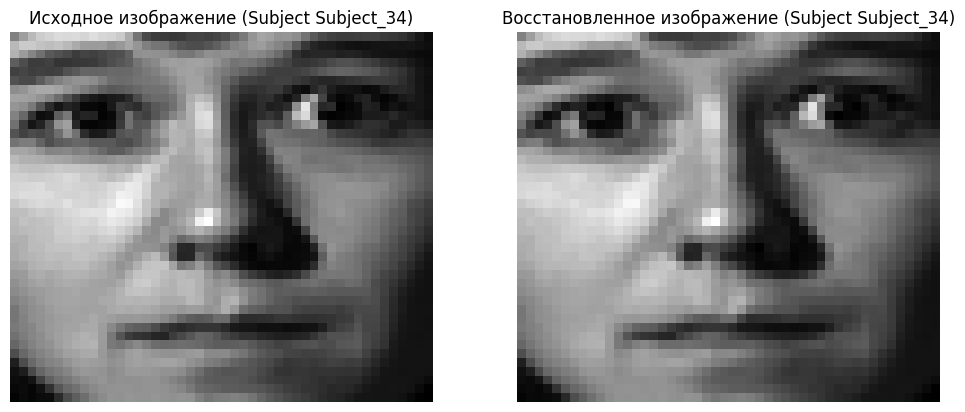


Сводка ошибок восстановления:
Subject Subject_12: Reconstruction error: 0.01312
Subject Subject_15: Reconstruction error: 0.01244
Subject Subject_23: Reconstruction error: 0.01346
Subject Subject_24: Reconstruction error: 0.01173
Subject Subject_25: Reconstruction error: 0.01286
Subject Subject_22: Reconstruction error: 0.01566
Subject Subject_13: Reconstruction error: 0.00934
Subject Subject_31: Reconstruction error: 0.00976
Subject Subject_36: Reconstruction error: 0.01038
Subject Subject_09: Reconstruction error: 0.00925
Subject Subject_07: Reconstruction error: 0.00971
Subject Subject_38: Reconstruction error: 0.00992
Subject Subject_06: Reconstruction error: 0.01164
Subject Subject_39: Reconstruction error: 0.01197
Subject Subject_01: Reconstruction error: 0.00911
Subject Subject_37: Reconstruction error: 0.00755
Subject Subject_08: Reconstruction error: 0.01203
Subject Subject_30: Reconstruction error: 0.01204
Subject Subject_29: Reconstruction error: 0.01316
Subject Subject_16:

In [11]:
# Параметры
epsilon = 1e-2  # Порог сходимости

# Словари для хранения ядер и факторов
cores_by_subject = {}
factors_by_subject = {}
reconstruction_errors = {}

# Рассчет точности восстановления и отображение примеров
for subject, tensor in tensors_by_subject.items():
    # Определение рангов для Tucker-декомпозиции
    ranks = [min(tensor.shape)] * len(tensor.shape)
    
    # Выполнение Tucker-декомпозиции
    core, factors = tucker(tensor, rank=ranks, tol=epsilon, random_state=SEED)
    reconstructed_tensor = tucker_to_tensor((core, factors))
    
    # Подсчет ошибки восстановления
    reconstruction_error = np.linalg.norm(tensor - reconstructed_tensor) / np.linalg.norm(tensor)
    reconstruction_errors[subject] = reconstruction_error
    
    # Сохранение ядра и факторов
    cores_by_subject[subject] = core
    factors_by_subject[subject] = factors
    
    # Вывод формы ядра и факторов
    print(f"Subject {subject}: Core shape {core.shape}")
    print(f"Subject {subject}: Factors shapes {[f.shape for f in factors]}")
    print(f"Subject {subject}: Reconstruction error: {reconstruction_error:.5f}")
    
    # Визуализация примера для текущего субъекта
    plt.figure(figsize=(12, 6))

    # Исходное изображение
    plt.subplot(1, 2, 1)
    plt.imshow(tensor[:, :, tensor.shape[-1] // 2], cmap="gray")
    plt.title(f"Исходное изображение (Subject {subject})")
    plt.axis("off")

    # Восстановленное изображение
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_tensor[:, :, tensor.shape[-1] // 2], cmap="gray")
    plt.title(f"Восстановленное изображение (Subject {subject})")
    plt.axis("off")
    
    plt.show()

# Вывод общих ошибок восстановления
print("\nСводка ошибок восстановления:")
for subject, error in reconstruction_errors.items():
    print(f"Subject {subject}: Reconstruction error: {error:.5f}")

# Construction of the joint modal tensor 𝐴


Стекуем модальные тензоры 𝑀1, 𝑀2, …, 𝑀𝐷 по третьему измерению (или создаем объединенный тензор), получая тензор 𝐴.

In [12]:
# # Step 1: Extract factor matrices and rank information from Tucker decomposition
# # A_hat, B_hat, and C_hat represent the factor matrices for modes 1, 2, and 3, respectively.
# A_hat, B_hat, C_hat = factors  # Decomposed factor matrices
# R = core.shape[2]  # Number of temporal modes (rank along the third dimension)

# # Step 2: Compute time-irrelevant modal matrices using TensorLy's mode_dot
# # Initialize an empty list to store the modal matrices for each temporal mode
# M_list = []

# for n in range(R):
#     # Slice the core tensor along the third dimension to get the nth mode's core slice
#     G_slice = core[:, :, n]  # Extract the (I x J) core slice for the nth temporal mode

#     # Compute the modal matrix M_n for the nth mode using mode_dot
#     # Apply mode_dot for the first mode with A_hat
#     M_n = mode_dot(G_slice, A_hat, mode=0)  # Multiply along the 0th mode

#     # Apply mode_dot for the second mode with B_hat
#     M_n = mode_dot(M_n, B_hat, mode=1)  # Multiply along the 1st mode

#     # Append the computed modal matrix to the list
#     M_list.append(M_n)

# # Step 3: Stack the computed modal matrices to form the final tensor
# # The final tensor A_tensor will have dimensions (I, J, R), where R is the number of temporal modes
# A_tensor = tl.stack(M_list, axis=-1)

# # Step 4: Validate the dimensions of the resulting tensor
# print(f"Размер тензора временно-нечувствительных мод: {A_tensor.shape}")


In [13]:
# Словарь для хранения временно-нечувствительных модальных тензоров
M_tensors = {}

# Итерация по всем субъектам с использованием данных из cores_by_subject и factors_by_subject
for subject in cores_by_subject.keys():
    # Получаем ядро и матрицы факторов для текущего субъекта
    core = cores_by_subject[subject]
    factors = factors_by_subject[subject]
    
    # Извлечение матриц факторов
    A_hat, B_hat, C_hat = factors
    R = core.shape[2]  # Число временных мод (ранг по третьему измерению)
    
    # Список для хранения модальных матриц
    M_list = []
    
    for n in range(R):
        # Срез ядра по третьему измерению
        G_slice = core[:, :, n]
        
        # Вычисление модальной матрицы M_n
        # M_n = A * G_slice * B^T
        M_n = mode_dot(G_slice, A_hat, mode=0)  # Умножение по 0-й размерности
        M_n = mode_dot(M_n, B_hat, mode=1)  # Умножение по 1-й размерности
        
        # Добавление модальной матрицы в список
        M_list.append(M_n)
    
    # Формирование финального тензора
    modal_tensor = tl.stack(M_list, axis=-1)  # Размерность (I, J, R)
    
    # Сохранение тензора для текущего субъекта
    M_tensors[subject] = modal_tensor
    
    # Вывод размера тензора
    print(f"Subject {subject}: Размер тензора временно-нечувствительных мод: {modal_tensor.shape}")


Subject Subject_12: Размер тензора временно-нечувствительных мод: (42, 48, 42)
Subject Subject_15: Размер тензора временно-нечувствительных мод: (42, 48, 42)
Subject Subject_23: Размер тензора временно-нечувствительных мод: (42, 48, 42)
Subject Subject_24: Размер тензора временно-нечувствительных мод: (42, 48, 42)
Subject Subject_25: Размер тензора временно-нечувствительных мод: (42, 48, 42)
Subject Subject_22: Размер тензора временно-нечувствительных мод: (42, 48, 42)
Subject Subject_13: Размер тензора временно-нечувствительных мод: (42, 48, 42)
Subject Subject_31: Размер тензора временно-нечувствительных мод: (42, 48, 42)
Subject Subject_36: Размер тензора временно-нечувствительных мод: (42, 48, 42)
Subject Subject_09: Размер тензора временно-нечувствительных мод: (42, 48, 42)
Subject Subject_07: Размер тензора временно-нечувствительных мод: (42, 48, 42)
Subject Subject_38: Размер тензора временно-нечувствительных мод: (42, 48, 42)
Subject Subject_06: Размер тензора временно-нечувств

In [14]:
# Initialize an empty list to store all flattened modes
all_modes = []

# Iterate over all subjects
for subject, modal_tensor in M_tensors.items():
    # Reshape the modal tensor to (I, J, R) and append its modes to the list
    I, J, R = modal_tensor.shape
    for r in range(R):
        all_modes.append(modal_tensor[:, :, r])  # Append each mode as a 2D slice

# Stack all modes along the 3rd dimension
A_tensor = np.stack(all_modes, axis=-1)  # Resulting shape: (I, J, W)

# Validate the shape of the resulting tensor
print(f"Final stacked tensor shape (A): {A_tensor.shape}")


Final stacked tensor shape (A): (42, 48, 1596)


# Application of Tensor QR Decomposition for Optimal Sensor Placement

Теперь нам нужно применить тензорное QR-разложение к тензору 𝐴 для получения матрицы перестановок 𝑃, которая будет использоваться для оптимального размещения сенсоров.

In [15]:
def visualize_sensor_placement(P):
    """
    Визуализирует размещение сенсоров на основе матрицы P с черным фоном и размером полотна, соответствующим изображению.
    
    Parameters:
    - P: Пермутационная матрица, где 1 указывает на размещение сенсора.
    """
    # Получение координат сенсоров
    sensor_positions = np.argwhere(P == 1)
    
    # Размерность сетки
    grid_shape = P.shape
    
    # Создание полотна
    fig, ax = plt.subplots(figsize=(grid_shape[1] / 10, grid_shape[0] / 10))  # Размер полотна
    ax.set_facecolor("black")  # Установка черного фона полотна

    # Создание черной сетки
    ax.imshow(np.zeros(grid_shape), cmap="gray", origin="upper")  # Черная сетка
    
    # Нанесение сенсоров (красные точки)
    ax.scatter(sensor_positions[:, 1], sensor_positions[:, 0], c="red", s=20, label="Sensors")  # s задает размер точек
    
    # Настройка отображения
    ax.set_title("Sensor Placement", color="white", fontsize=10)
    ax.legend(loc="upper right", frameon=False, fontsize=8, labelcolor="white")
    ax.axis("off")  # Убираем оси
    ax.set_aspect("auto")  # Убираем автоматическое масштабирование
    
    # Показ графика
    plt.show()

In [16]:
def compute_householder_vector(t, d):
    """
    Computes the Householder vector u to reflect t to a multiple of e1.
    
    Parameters:
    - t: numpy array, the input vector
    
    Returns:
    - u: numpy array, the Householder vector
    """
    sigma = np.linalg.norm(t, ord=2)
    e1 = np.zeros_like(t)
    e1[d] = 1
    
    # Улучшенная обработка sign(t[0])
    sign_t1 = np.sign(t[0]) if t[0] != 0 else 1
    
    u = t + sign_t1 * sigma * e1
    denominator = np.sqrt(2 * sigma * (sigma + np.abs(t[0])))
    
    # Обработка вырожденного случая
    if np.abs(denominator) < 1e-10:
        return np.zeros_like(t)
    
    u = u / denominator
    return u.reshape(-1, 1)

def tensor_based_tube_fiber_pivot_qr_factorization(X_tensor: np.ndarray, N: int) -> tuple:
    """
    Implements the Tensor-based Tube Fiber-pivot QR Factorization.

    Parameters:
    - X_tensor: Input 3D numpy array of shape (n1 x n2 x m).
    - N: Number of iterations for the factorization (number of selected sensors).

    Returns:
    - P: Permutation matrix of shape (n1 x n2) indicating sensor placement.
    - Q: Orthogonal matrix of shape (m x m).
    - R: Updated tensor after applying Householder transformations.
    """
    n1, n2, m = X_tensor.shape
    P = np.zeros((n1, n2), dtype=int)
    Q = np.eye(m)
    R = X_tensor.copy()
    
    rejection_domain = set()
    
    for d in range(N):
        # Вычисление трубных норм
        tube_norms = np.linalg.norm(R.reshape(n1, n2, -1), axis=2, ord=1)
        
        # Максимальная l∞-норма
        x, y = np.unravel_index(np.argmax(tube_norms), tube_norms.shape)
        
        # Проверка на принадлежность к rejection domain
        while (x, y) in rejection_domain and tube_norms[x, y] > 0:
            tube_norms[x, y] = 0
            x, y = np.unravel_index(np.argmax(tube_norms), tube_norms.shape)
        
        # Обновление Permission и Rejection Domain
        P[x, y] = 1
        rejection_domain.add((x, y))
        
        # Извлечение трубного волокна
        t = R[x, y, d:]
        
        # Вычисление вектора Хаусхолдера
        u = compute_householder_vector(t, d)
        
        # Обновление R и Q
        R[x, y, d:] -= 2 * (u @ u.T @ R[x, y, d:])
        Q[:, d:] -= 2 * (Q[:, d:] @ (u @ u.T))
    
    return P, Q, R

In [17]:
tensor_3d = np.random.rand(3, 3, 3)  # Заполняем случайными float значениями от 0 до 1

In [18]:
tensor_3d

array([[[0.37454012, 0.95071431, 0.73199394],
        [0.59865848, 0.15601864, 0.15599452],
        [0.05808361, 0.86617615, 0.60111501]],

       [[0.70807258, 0.02058449, 0.96990985],
        [0.83244264, 0.21233911, 0.18182497],
        [0.18340451, 0.30424224, 0.52475643]],

       [[0.43194502, 0.29122914, 0.61185289],
        [0.13949386, 0.29214465, 0.36636184],
        [0.45606998, 0.78517596, 0.19967378]]])

In [19]:
# Параметры для QR-разложения
N = 363  # Задайте количество сенсоров

# Применяем функцию (не забудьте адаптировать функцию под ваши данные)
P, Q, R = tensor_based_tube_fiber_pivot_qr_factorization(A_tensor, N)

In [20]:
Q_T_Q = tl.dot(Q.T, Q)
identity = tl.tensor(np.eye(A_tensor.shape[2]), dtype=tl.float32)
difference = tl.norm(Q_T_Q - identity)


print(f"\nНорма (Q^T Q - I): {difference}")


Норма (Q^T Q - I): 2.2786887309254467


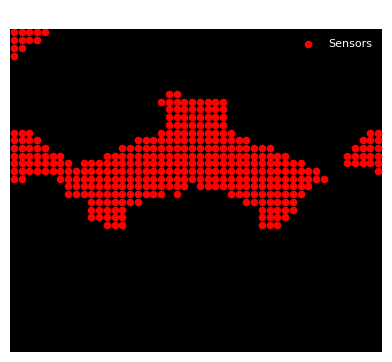

In [21]:
visualize_sensor_placement(P)

# Formation of dimensions 𝑌


После получения матрицы 𝑃 вы можете сформировать матрицу измерений 𝑌 из исходного тензора 𝑋.

In [22]:
X = tensor[:,:,43]

Y = P * X

# Проверка формы Y
print(f"Размерность Y: {Y.shape}")

# Вывод для проверки
print("Матрица P (расположение сенсоров):")
print(P)

print("Результирующая матрица Y:")
print(Y)

Размерность Y: (42, 48)
Матрица P (расположение сенсоров):
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Результирующая матрица Y:
[[0.1882353  0.24705882 0.29803923 ... 0.         0.         0.        ]
 [0.38039216 0.4627451  0.48235294 ... 0.         0.         0.        ]
 [0.3882353  0.3882353  0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


# Tensor compression measurement

Теперь нужно решить оптимизационную задачу для восстановления вектора весов 𝑥, используя измерения 𝑌 и тензор 𝐴.

In [23]:
# def tensor_mode3_multiplication(tensor, matrix):
#     """
#     Умножает матрицу на тензор вдоль третьего измерения (mode-3).
    
#     Параметры:
#     - tensor: numpy.ndarray, тензор размерности (I, J, K).
#     - matrix: numpy.ndarray, матрица размерности (M, K).

#     Возвращает:
#     - Результирующий тензор размерности (I, J, M).
#     """
#     # Проверяем совместимость размеров
#     print(f"Размер P: {matrix.shape}")
#     print(f"Размер A: {tensor.shape}")
    
#     I, J, K = tensor.shape
#     M, K_matrix = matrix.shape
    
#     if K != K_matrix:
#         raise ValueError(f"Размеры несовместимы: K тензора ({K}) и K матрицы ({K_matrix}) должны совпадать.")
    
#     # Создаем пустой массив для результирующего тензора
#     result_tensor = np.zeros((I, J, M))
    
#     # Выполняем умножение вдоль третьего измерения
#     for i in range(I):
#         for j in range(J):
#             result_tensor[i, j, :] = matrix @ tensor[i, j, :]
    
#     return result_tensor

In [24]:
def tensor_based_compressive_sensing(
    A: Union[np.ndarray, tl.tensor],
    P: Union[np.ndarray, tl.tensor],
    Y: Union[np.ndarray, tl.tensor],
    max_iter: int,
    epsilon: float,
    lambd: float,
    delta_0: float,
    delta_max: float
) -> tl.tensor:
    """
    Implements the Tensor-based Compressive Sensing Algorithm (Algorithm 3).
    
    Parameters:
    - A: Input tensor of shape (I x J x W) (numpy array or Tensorly tensor)
    - P: Permutation matrix or sensor selection matrix (numpy array or Tensorly tensor)
    - Y: Observed data tensor (after sensor placement) (numpy array or Tensorly tensor)
    - max_iter: Maximum number of iterations (int)
    - epsilon: Small positive scalar for shrinkage thresholding (float)
    - lambd: Regularization parameter (float)
    - delta_0: Initial value for the Lagrange penalty term (float)
    - delta_max: Maximum value for delta (float)
    
    Returns:
    - x_hat: Recovered sparse code vector of shape (W x 1) (Tensorly tensor)
    """
    
    # Ensure A, P, Y are tensors
    A = tl.tensor(A, dtype=tl.float32)
    P = tl.tensor(P, dtype=tl.float32)
    Y = tl.tensor(Y, dtype=tl.float32)
    
    # Preprocess A: A = P x0 A
    A = mode_dot(P, A, mode=0)  # A now has shape (I, J, W)
    
    # Get dimensions
    N, J, W = A.shape
    
    # Initialize variables
    x_n = tl.zeros((W, 1), dtype=tl.float32)
    d_n = tl.zeros((W, 1), dtype=tl.float32)
    p_n = tl.zeros((W, 1), dtype=tl.float32)
    delta_n = delta_0
    
    # Unfold A along mode-2 (mode-3 in MATLAB notation)
    A_unfold = tl.unfold(A, mode=2)  # Shape: (W, N*J)
    
    # Compute A_T_A and A_Y
    A_T_A = A_unfold @ A_unfold.T  # Shape: (W, W)
    Y_vector = Y.reshape(-1, 1)  # Shape: (N*J, 1)
    A_Y = A_unfold @ Y_vector  # Shape: (W, 1)
    
    # Start iterations
    for n in range(1, max_iter + 1):
        # Update x_n
        left_matrix = A_T_A + delta_n * np.eye(W)
        right_vector = A_Y + delta_n * (d_n - p_n)
        x_n = np.linalg.solve(left_matrix, right_vector)
        
        # Compute x_hat
        x_hat = lambd * x_n + (1 - lambd) * d_n
        
        # Update d_n using iterative shrinkage-thresholding
        threshold = epsilon / delta_n
        temp = x_hat + p_n
        d_n = np.maximum(0, temp - threshold) - np.maximum(0, -temp - threshold)
        
        # Update p_n
        p_n = p_n + x_hat - d_n
        
        # Update delta_n
        delta_n = min(delta_n, delta_max)
    
    return x_hat

In [25]:
# Гиперпараметры для компрессивного измерения
max_iter = 1000
epsilon_cs = 1e-2  # Используем другое имя для epsilon, чтобы не путать с предыдущим
lambda_ = 0.95
delta_0 = 0.01
delta_max = 0.01

x_hat = tensor_based_compressive_sensing(
    A_tensor, P, Y, max_iter, epsilon_cs, lambda_, delta_0, delta_max
)

ValueError: Can only take n_mode_product with a vector or a matrix.Provided array of dimension 3 not in [1, 2].

# Field restoration 𝑋

Используя полученный вектор весов 𝑥, мы можем восстановить поле 𝑋.

In [ ]:
# Восстанавливаем тензорное поле
# x_hat должен быть размерности (R,)
X_reconstructed = tl.tenalg.mode_dot(A_tensor, x_hat.squeeze(), mode=2)  # Применяем x_hat по третьему измерению

# X_reconstructed будет тензором размерности (I, J)

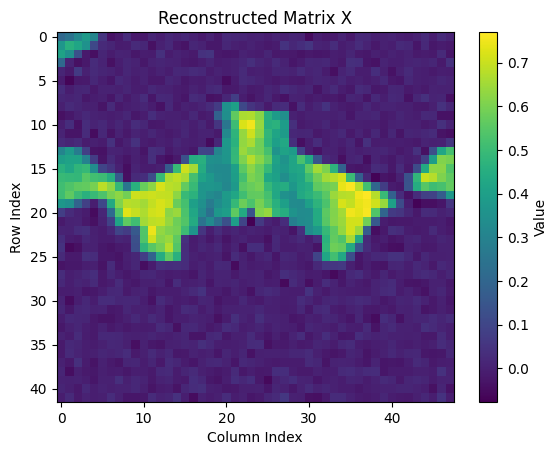

In [ ]:
# Plot the reconstructed matrix
plt.imshow(X_reconstructed, cmap='viridis', aspect='auto')
plt.colorbar(label='Value')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.title('Reconstructed Matrix X')
plt.show()

In [ ]:
def mode3_product(A, x):
    """
    Computes the mode-3 product of a tensor A with a vector x.
    
    Parameters:
    - A: numpy.ndarray, a 3D tensor of shape (I, J, K)
    - x: numpy.ndarray, a 1D vector of shape (K,)
    
    Returns:
    - X: numpy.ndarray, a 2D matrix of shape (I, J)
    """
    # Check if x is a column vector, if so, reshape it to 1D
    if x.ndim == 2 and x.shape[1] == 1:
        x = x.flatten()
    
    # Check dimension compatibility
    if A.shape[2] != x.shape[0]:
        raise ValueError("The third dimension of A must match the size of x.")
    
    # Compute the mode-3 product using einsum
    X = np.einsum('ijk,k->ij', A, x)
    
    return X


# Reconstruct the field matrix X
X_reconstructed = mode3_product(A_tensor, x_hat)

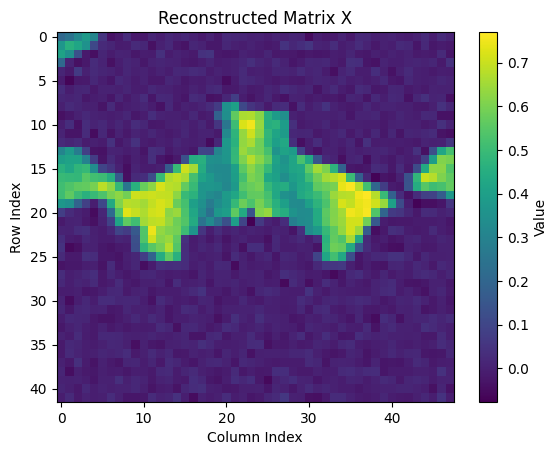

In [ ]:
# Plot the reconstructed matrix
plt.imshow(X_reconstructed, cmap='viridis', aspect='auto')
plt.colorbar(label='Value')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.title('Reconstructed Matrix X')
plt.show()